In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
# Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential
from keras.regularizers import l2
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#Visualization
import matplotlib.cm as cm
from sklearn import random_projection
# statmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
import datetime

import warnings
import itertools
warnings.filterwarnings("ignore")
#plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

In [3]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Quantity':'float32',
    'Total_Sales':'float32',
    'Value':'float32',
    'Week': 'int32',
    'Year':'int32'
}
original_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'
processed_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_final_1.csv'
timeseries_path = r'D:\NOVAIMS_MAA\timeseries\product_total_ts.csv'

In [4]:
example = pd.read_csv(processed_path,dtype=dtype_dict,parse_dates=['Date'],nrows = 100,usecols = [1,2,3,4,5,6,7,8,9])
example.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Total_Sales
0,16,11,306,649,1970,1,2017-03-04,2.0,1540.0
1,16,11,306,649,1970,1,2016-05-02,4.0,3080.0
2,16,11,306,649,1970,1,2016-10-24,2.0,1540.0
3,16,11,306,649,1970,1,2017-10-13,2.0,1620.0
4,16,11,306,649,1970,1,2017-10-14,2.0,1620.0


In [5]:
df = pd.read_csv(timeseries_path,dtype=dtype_dict,usecols = [1,2,3,4,5])

In [6]:
df.head()

,Year,Month,Week,ProductName_ID,Quantity
0,2016,1,1,1000,766.0
1,2016,1,1,1004,727.0
2,2016,1,1,1006,491.0
3,2016,1,1,1007,636.0
4,2016,1,1,1013,1641.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7174080 entries, 0 to 7174079
Data columns (total 5 columns):
 #   Column          Dtype   
---  ------          -----   
 0   Year            int32   
 1   Month           int64   
 2   Week            int32   
 3   ProductName_ID  category
 4   Quantity        float32 
dtypes: category(1), float32(1), int32(2), int64(1)
memory usage: 150.6 MB


In [44]:
def getDateRangeFromWeek(x): 
    d = str(x['Year']) + "-W" + str(x['Week'])
    r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return r

def getDateRangeFromMonth(x): 
    if len(str(x['Month'])) ==1:
        m = "0" + str(x['Month'])
    else:   
        m = x['Month']
    d = str(x['Year']) + "-" +  m + "-" + "01"
    r = datetime.datetime.strptime(d, "%Y-%m-%d")
    return r

def preprocessing(dataframe,product_id, period = "Month"):
    if period == "Month":
        data = dataframe[dataframe['ProductName_ID'] == product_id]
        data = data.groupby(['Year','Month']).sum()['Quantity'].reset_index()
        data['Month'] =  data['Month'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data['TimeSeries'] = data[['Year','Month']].apply(getDateRangeFromMonth,axis  = 1)
        #drop non-relevant columns
        data.drop(['Year','Month'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.sort_index(inplace=True)
        print("monthly timeseries generated")
        return data
    elif period == "Week":
        data = dataframe[dataframe['ProductName_ID'] == product_id]
        data = data.groupby(['Year','Week']).sum()['Quantity'].reset_index()      
        data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data = data[data['Week'] != "53"]
        data['TimeSeries'] = data[['Year','Week']].apply(getDateRangeFromWeek,axis  = 1)
        #drop non-relevant columns
        data.drop(['Year','Week'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.dropna(inplace=True)
        data.sort_index(inplace=True)
        print("weekly timeseries generated")
        return data
    else:
        print("Error, chosen period not available")   

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
# evaluate the RMSE for each forecast time step

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def plot_series(data,figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data)      

# plot the forecasts in the context of the original dataset
def plot_forecasts(series,train_df, val_df, forecasts, out):
    plt.figure(figsize=(12,6))
    # plot the entire dataset in blue
    plt.plot(data.loc[train_df.index], label = "Train")
    plt.plot(data.loc[val_df.index], label = "Validation")
    if out == 1:
        lines = pd.Series()
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            lines = lines.append(pd.Series(yaxis[0],index = xaxis))
        plt.plot(lines.index, lines.values, color='red')
    # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
        return lines
	# plot the forecasts in red
    else:
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            plt.plot(xaxis, yaxis, color='red')
        # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
def gridSearchARIMA(data, seasonal = 12, searchRange = range(0,2)):
    p = q = searchRange
    d = range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('...')
    print('Running grid search...')
    arima_grid = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                arima_grid[f'{param}x{param_seasonal}'] = results.aic
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    model = min(arima_grid, key=arima_grid.get)
    print("Model have lowest AIC score:", model)
    print("AIC score:", arima_grid[model])
    return arima_grid

def modelARIMAfit(data, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12)):
    mod = sm.tsa.statespace.SARIMAX(data,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    return results

def oneStepForecast(results, data,test_len = 0.8):
    test_start = data.iloc[int(len(data)*test_len)].name
    pred = results.get_prediction(start=test_start, dynamic=False)
    pred_ci = pred.conf_int()
    # plot
    ax = data.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 6))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
    y_forecasted = pred.predicted_mean
    y_truth = data[test_start:]['Quantity'].values
    rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
    mape = mean_absolute_percentage_error(y_truth,y_forecasted)
    print('RMSE = {}'.format(round(rmse, 2)))
    print('MAPE = {}'.format(round(mape, 4)))
    return rmse, mape

def multiStepForecast(data, order, seasonal_order, test_len = 0.8, steps = 3):
    test_start = data.iloc[int(len(data)*test_len)].name
    test_stop = data.iloc[-steps].name
    oos_prediction = list()
    oos_actual = list()
    print(f"Calculating forecasts with {steps} steps ahead")
    for i,date in enumerate(data[test_start:test_stop].index):
        results = modelARIMAfit(data[:date][:-1], order = order, seasonal_order= seasonal_order)   
        pred_uc = results.get_forecast(steps=steps)
        oos_prediction.append(pred_uc.predicted_mean.values)
        oos_actual.append(data[date:][:steps]['Quantity'].values)
    return oos_prediction, oos_actual

def evaluateForecastARIMA(oos_prediction,oos_actual, steps = 3):
    for i in range(steps):
        actual = [row[i] for row in oos_actual]
        predicted = [forecast[i] for forecast in oos_prediction]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def multiStepForecast_future(results,steps):
    pred_uc = results.get_forecast(steps=steps)
    pred_ci = pred_uc.conf_int()
    ax = data.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
    return pred_uc.predicted_mean

In [9]:
# Check for top 10 products
df.groupby('ProductName_ID').sum()['Quantity'].sort_values(ascending = False)[:10]

ProductName_ID
1277    3170543.0
2609    3070767.0
481     2983412.0
993     2837871.0
1147    2801077.0
1234    2528432.0
2802    2521720.0
847     2447311.0
226     2437948.0
1422    2414555.0
Name: Quantity, dtype: float32

## Non-Seasonal product

In [10]:
data = preprocessing(df,product_id='2609')
# the last 2 months data is "error" so we remove them
data = data.iloc[:-2]

monthly timeseries generated


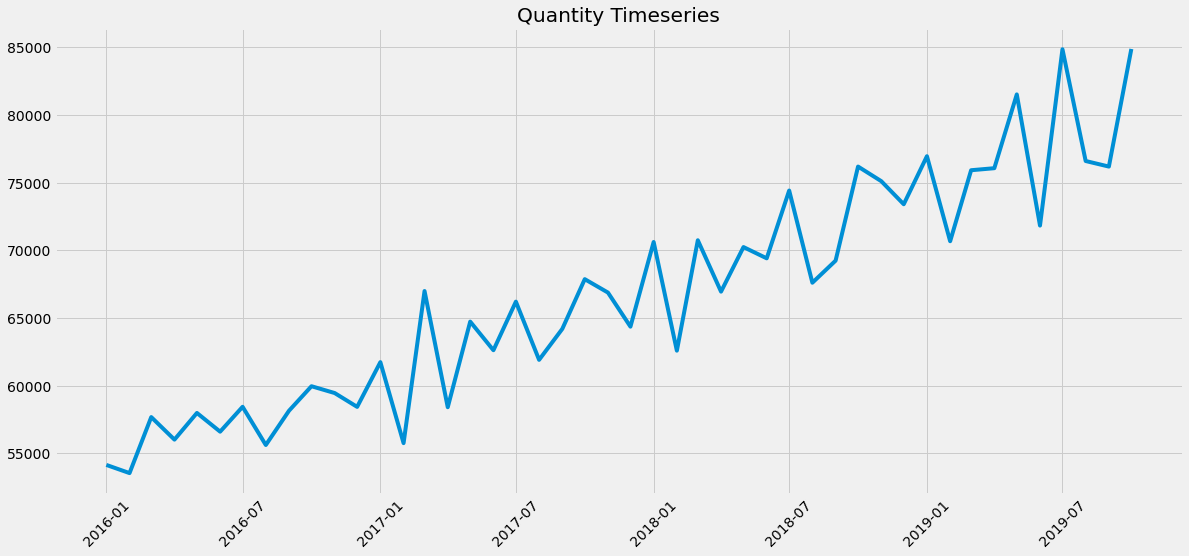

In [11]:
plot_series(data)

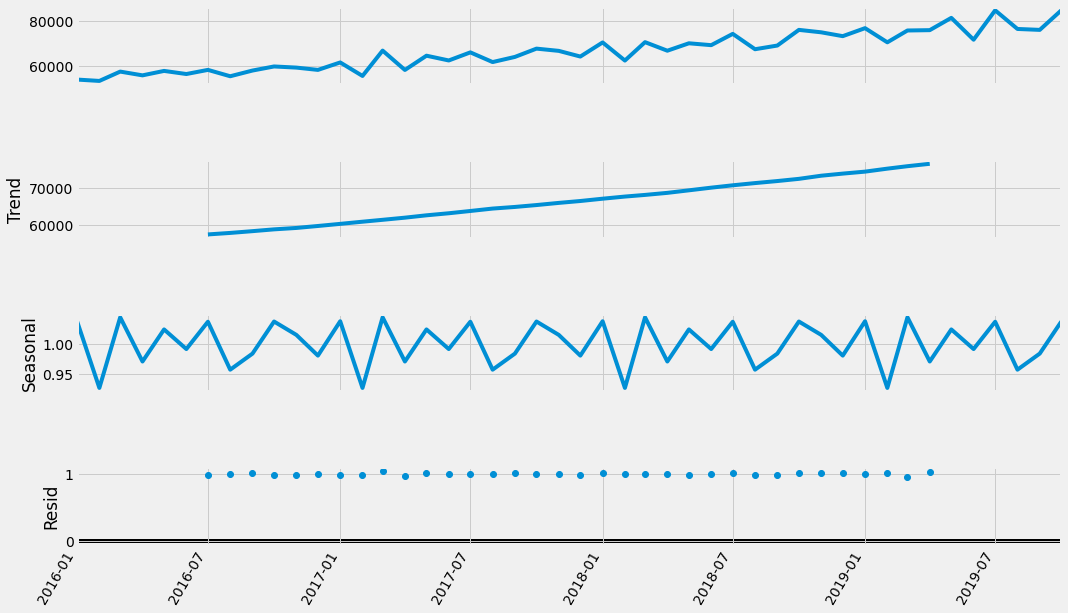

In [12]:
result = seasonal_decompose(data, model='multiplicative')
fig = result.plot()
fig.set_size_inches(18, 10)
fig.autofmt_xdate( bottom=0.2, rotation=60, ha='right', which='major')
#plot_mpl(fig)

In [19]:
arima_grid = gridSearchARIMA(data, seasonal = 12, range = range(0,2))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
...
Running grid search...
Model have lowest AIC score: (1, 1, 1)x(0, 1, 1, 12)
AIC score: 349.0596094177661


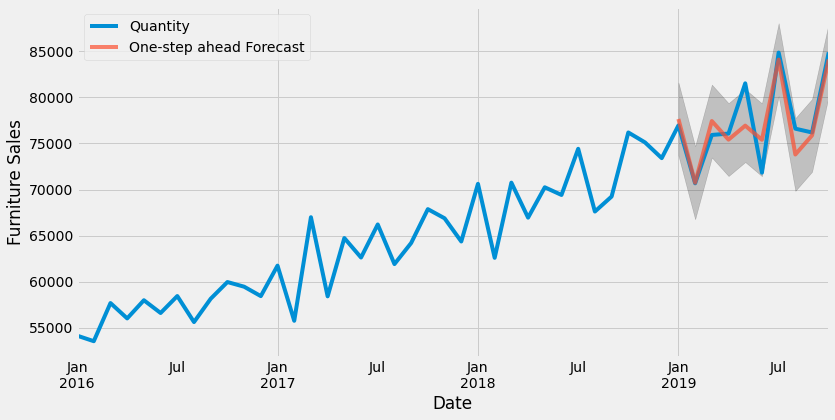

RMSE = 2146.52
MAPE = 0.0203


In [31]:
results = modelARIMAfit(data, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12))
rmse, mape = oneStepForecast(results, data)

In [32]:
oos_prediction, oos_actual = multiStepForecast(data, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12), test_len = 0.8, steps = 3)
evaluateForecastARIMA(oos_prediction,oos_actual)

Calculating forecasts with 3 steps ahead
t+1 RMSE: 2743.157528
t+1 MAPE: 0.0285
t+2 RMSE: 2955.684279
t+2 MAPE: 0.0334
t+3 RMSE: 2792.474521
t+3 MAPE: 0.0316


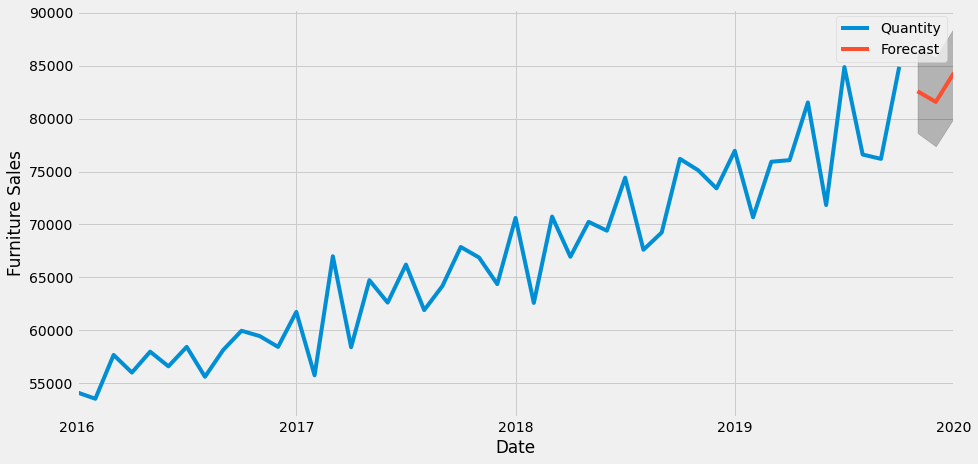

2019-11-01    82575.131618
2019-12-01    81571.351508
2020-01-01    84324.861803
Freq: MS, Name: predicted_mean, dtype: float64

In [22]:
results = modelARIMAfit(data, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12))
multiStepForecast_future(results,steps = 3)

## Seasonal product

In [10]:
data = preprocessing(df,product_id='481')
data = data.iloc[:-2]

monthly timeseries generated


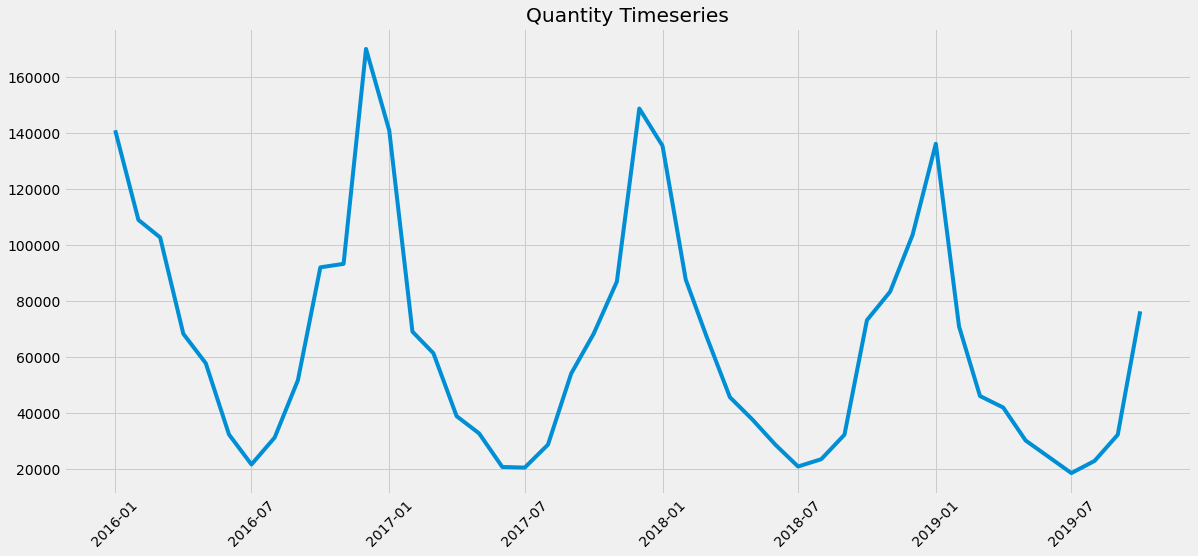

In [11]:
plot_series(data)

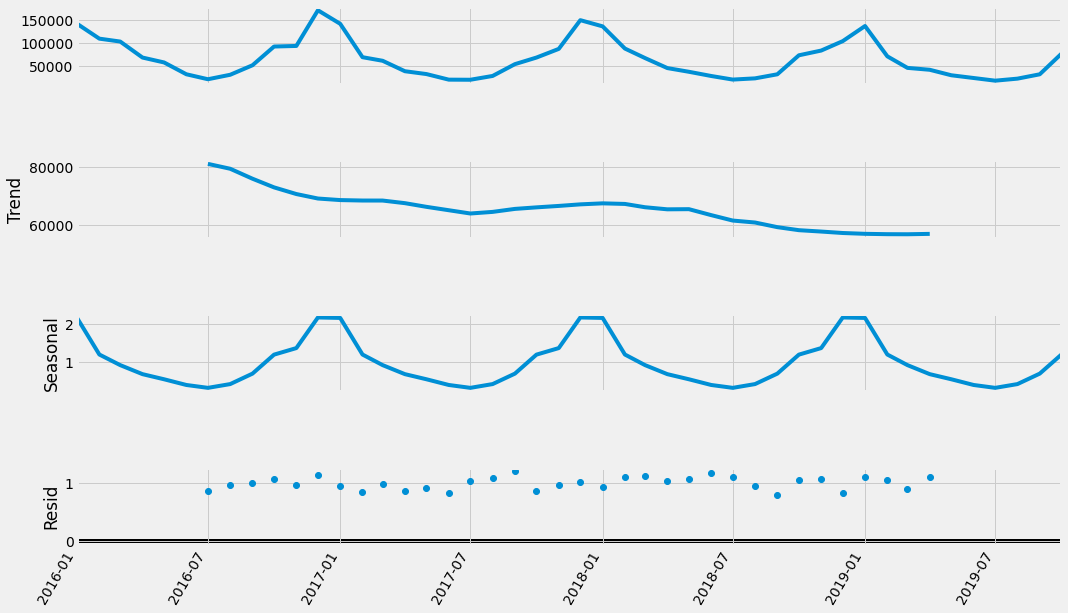

In [12]:
result = seasonal_decompose(data, model='multiplicative')
fig = result.plot()
fig.set_size_inches(18, 10)
fig.autofmt_xdate( bottom=0.2, rotation=60, ha='right', which='major')

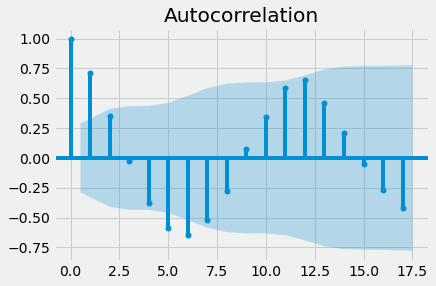

In [13]:
plot_acf(data)
plt.show()

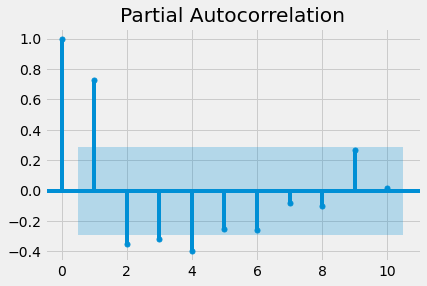

In [14]:
plot_pacf(data, lags=10)
plt.show()

In [17]:
data = preprocessing(df,product_id='481')
data = data.iloc[:-2]
arima_grid = gridSearchARIMA(data, seasonal = 12, searchRange= range(0,3))

monthly timeseries generated
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
...
Running grid search...
Model have lowest AIC score: (0, 1, 2)x(0, 1, 2, 12)
AIC score: 136.23110286943822


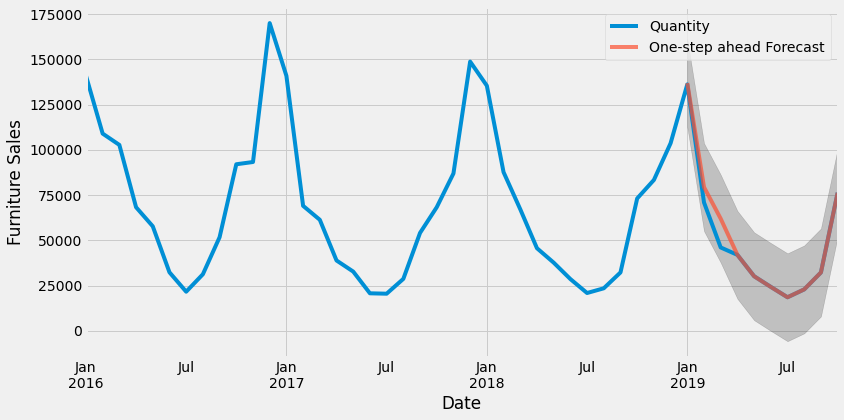

RMSE = 5700.52
MAPE = 0.0473
Calculating forecasts with 3 steps ahead
t+1 RMSE: 7883.669313
t+1 MAPE: 0.1370
t+2 RMSE: 8228.256964
t+2 MAPE: 0.1631
t+3 RMSE: 5840.914921
t+3 MAPE: 0.1108


In [41]:
order = (4, 0, 2)
seasonal_order= (0, 1, 2, 12)
# 1 step ahead forecast
results = modelARIMAfit(data, order = order, seasonal_order= seasonal_order)
rmse, mape = oneStepForecast(results, data)
# out-of-sample forecast
oos_prediction, oos_actual = multiStepForecast(data, order = order, seasonal_order= seasonal_order, test_len = 0.8, steps = 3)
evaluateForecastARIMA(oos_prediction, oos_actual)

# Weekly forecasting

weekly timeseries generated


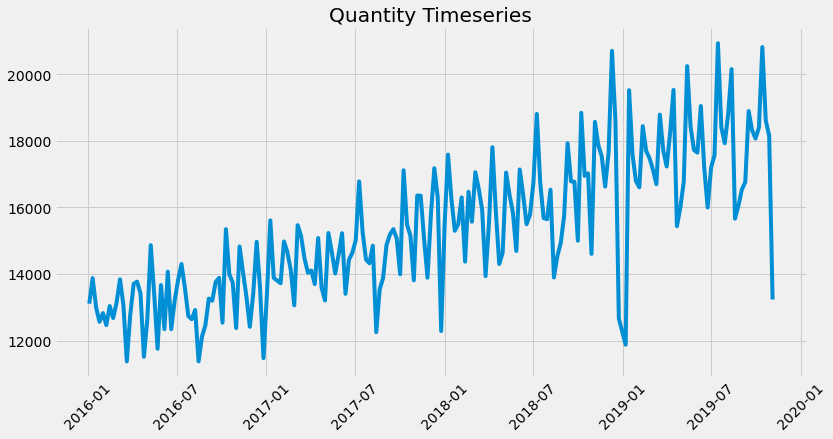

In [47]:
data = preprocessing(df,product_id='2609',period="Week")
# the last 2 months data is "error" so we remove them
data = data.iloc[:-8]
plot_series(data)

In [56]:
def difference(dataset, interval=1):
    diff = list()
    dataset_val = dataset.values
    for i in range(interval, len(dataset)):
        value = dataset_val[i] - dataset_val[i - interval]
        diff.append(value[0])
    return pd.DataFrame({'diff':diff},index = dataset[1:].index)

In [64]:
#data = difference(data)

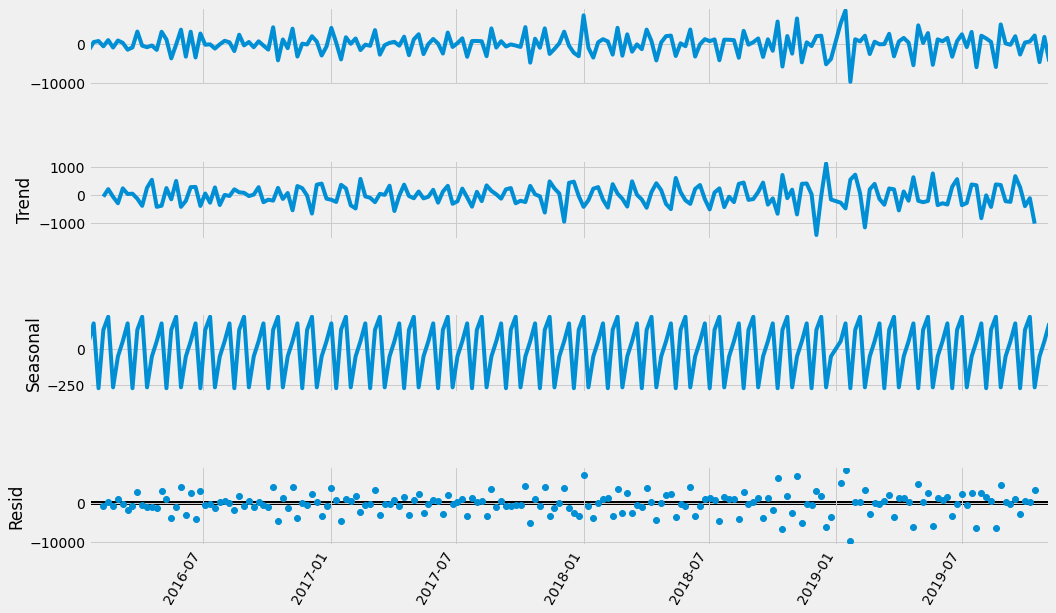

In [65]:
result = seasonal_decompose(data, model='additive',period = 7)
fig = result.plot()
fig.set_size_inches(18, 10)
fig.autofmt_xdate( bottom=0.2, rotation=60, ha='right', which='major')

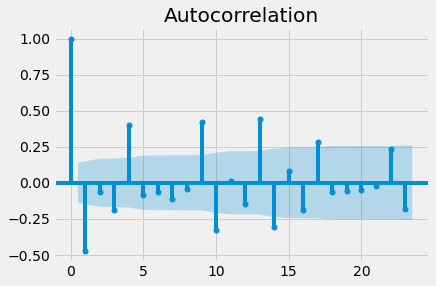

In [66]:
plot_acf(data)
plt.show()

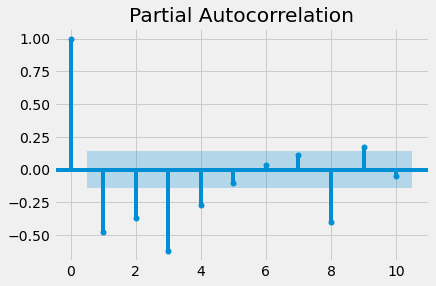

In [67]:
plot_pacf(data, lags=10)
plt.show()

In [70]:
data = preprocessing(df,product_id='2609',period="Week")
data = data.iloc[:-8]
arima_grid = gridSearchARIMA(data, seasonal = 52, searchRange= range(0,2))

weekly timeseries generated
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
...
Running grid search...
Model have lowest AIC score: (0, 1, 1)x(0, 1, 1, 52)
AIC score: 1565.2809323558538


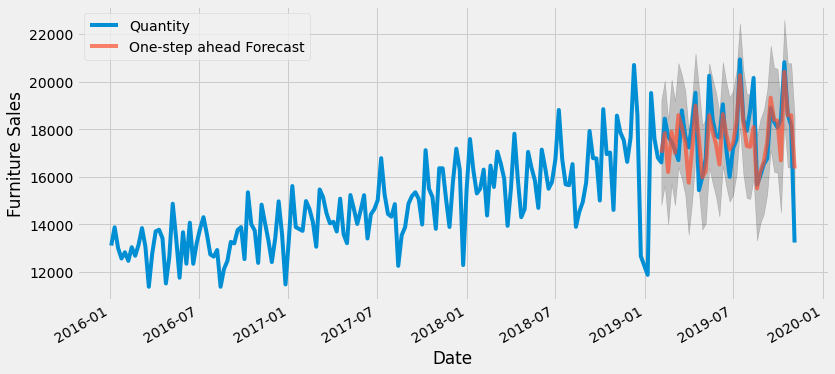

RMSE = 1046.29
MAPE = 0.0451
Calculating forecasts with 6 steps ahead
t+1 RMSE: 831.931540
t+1 MAPE: 0.0335
t+2 RMSE: 892.308509
t+2 MAPE: 0.0350
t+3 RMSE: 898.409135
t+3 MAPE: 0.0355


In [72]:
order = (0, 1, 1)
seasonal_order= (0, 1, 1, 52)
# 1 step ahead forecast
results = modelARIMAfit(data, order = order, seasonal_order= seasonal_order)
rmse, mape = oneStepForecast(results, data)
# out-of-sample forecast
oos_prediction, oos_actual = multiStepForecast(data, order = order, seasonal_order= seasonal_order, test_len = 0.9, steps = 6)
evaluateForecastARIMA(oos_prediction, oos_actual)

Non seasonal

In [75]:
data = preprocessing(df,product_id='481',period="Week")
data = data.iloc[:-8]
#arima_grid = gridSearchARIMA(data, seasonal = 52, searchRange= range(0,2))

weekly timeseries generated


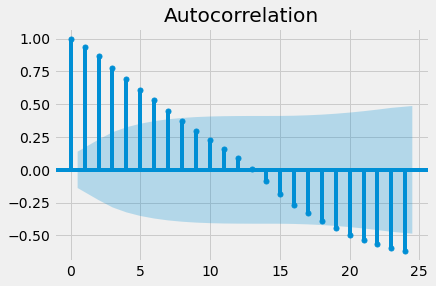

In [76]:
plot_acf(data)
plt.show()

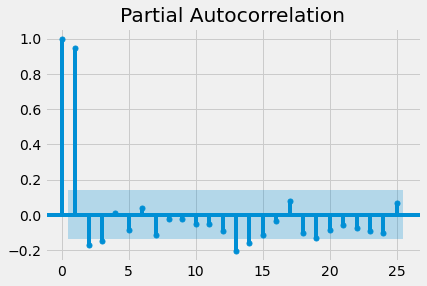

In [77]:
plot_pacf(data, lags=25)
plt.show()

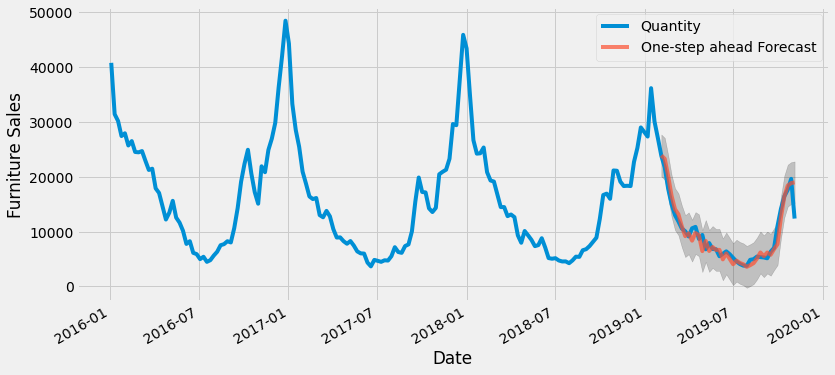

RMSE = 1589.9
MAPE = 0.1218
Calculating forecasts with 6 steps ahead
t+1 RMSE: 1067.625725
t+1 MAPE: 0.1216
t+2 RMSE: 1634.716451
t+2 MAPE: 0.1760
t+3 RMSE: 1870.050530
t+3 MAPE: 0.1783


In [82]:
order = (2, 1, 0)
seasonal_order= (0, 1, 1, 53)
# 1 step ahead forecast
results = modelARIMAfit(data, order = order, seasonal_order= seasonal_order)
rmse, mape = oneStepForecast(results, data,test_len=0.8)
# out-of-sample forecast
oos_prediction, oos_actual = multiStepForecast(data, order = order, seasonal_order= seasonal_order, test_len = 0.9, steps = 6)
evaluateForecastARIMA(oos_prediction, oos_actual)